In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import datetime as dt
from datetime import timedelta

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['data.csv']


In [2]:
df = pd.read_csv("../input/data.csv", encoding="ISO-8859-1")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df.isnull().sum()/df.shape[0]

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64

25% of CustomerID values are missing. It might be people who are not registered so they are buying without account. That's what I think at the first glance. But for purpose of this analysis I'm about to drop these rows.

In [5]:
df.dropna(subset=['CustomerID'], inplace=True)

In [6]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
print('Number of rows', df.shape[0])

Number of rows 406829


There are 406829 rows but as you can see 1 row is not equal to 1 transactions. Every row means 1 listing on the invoice.

In [8]:
#types
for c in ['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country']:
    df[c] = df[c].astype('category')
#dates    
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['DayOfWeek'] = df['DayOfWeek'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
df['Hour'] = df['InvoiceDate'].dt.hour

#invoice
df['StockValue'] = df['Quantity']*df['UnitPrice']

In [9]:
print(df['InvoiceDate'].min())
print(df['InvoiceDate'].max())
print(df['InvoiceDate'].max() - df['InvoiceDate'].min())

2010-12-01 08:26:00
2011-12-09 12:50:00
373 days 04:24:00


Period of analysis is 1 year with additional couple days.

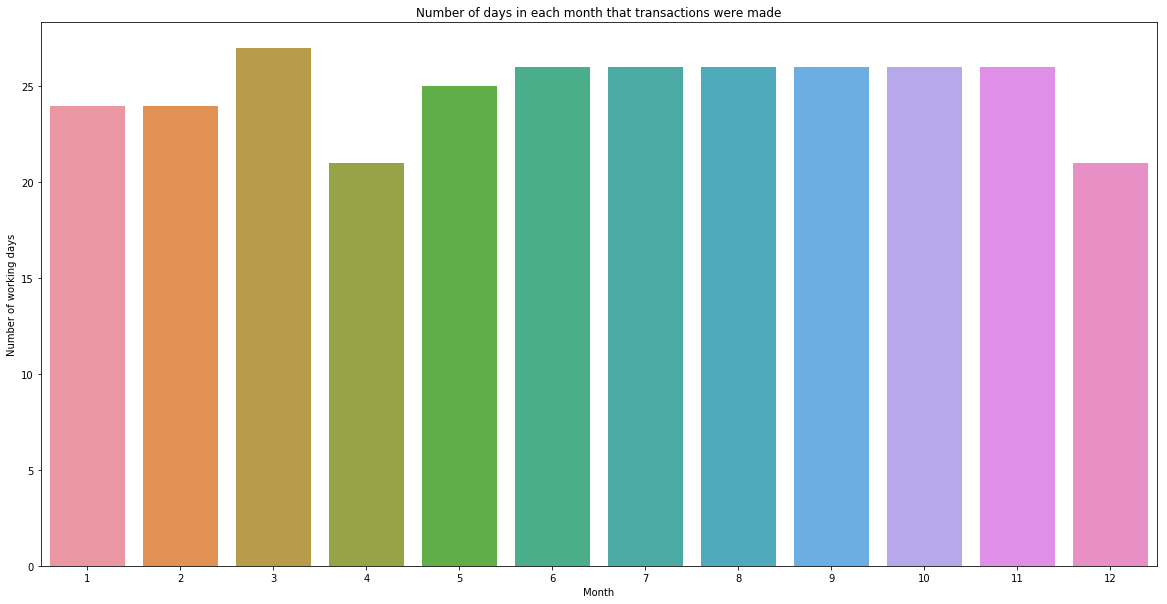

In [10]:
date_group = df.groupby('Month')['Day'].nunique()
plt.figure(figsize=(20,10))
sns.barplot(date_group.index, date_group.values)
plt.ylabel('Number of working days')
plt.xlabel('Month')
plt.title('Number of days in each month that transactions were made')
plt.show()

I would say that variation of working days over the year is constant.

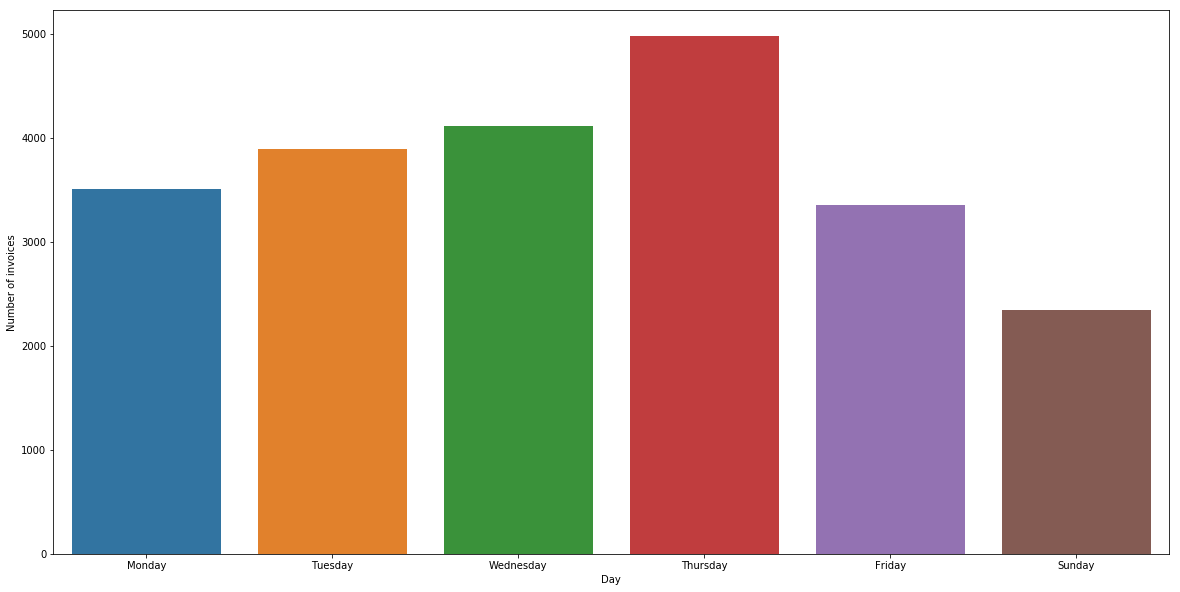

In [11]:
dayweek_group = df.groupby('DayOfWeek')['InvoiceNo'].nunique()
plt.figure(figsize=(20,10))
sns.barplot(dayweek_group.index, dayweek_group.values, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday'])
plt.ylabel('Number of invoices')
plt.xlabel('Day')
plt.show()

Interesting fact is that there are no transactions on Saturday at all.

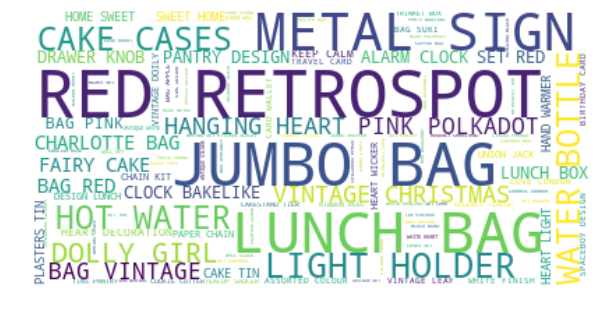

In [12]:
text = " ".join(review for review in df['Description'])
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Picture above shows the most frequent items that were bought.

In [13]:
def column_statistic(column):
    plt.figure(figsize=(20,10))
    sns.boxplot(df[column])
    print(df[column].describe())
    print('-'*10)
    print('Variation coefficient {}'.format(df[column].std()/df[column].mean()))
    print('-'*10)
    print('Minimum values')
    print(df[column].sort_values().head(5))
    print('Maximum values')
    print(df[column].sort_values(ascending=False).head(5))

count    406829.000000
mean         12.061303
std         248.693370
min      -80995.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64
----------
Variation coefficient 20.61911236435448
----------
Minimum values
540422   -80995
61624    -74215
4287      -9360
160145    -3114
160144    -2000
Name: Quantity, dtype: int64
Maximum values
540421    80995
61619     74215
502122    12540
421632     4800
206121     4300
Name: Quantity, dtype: int64


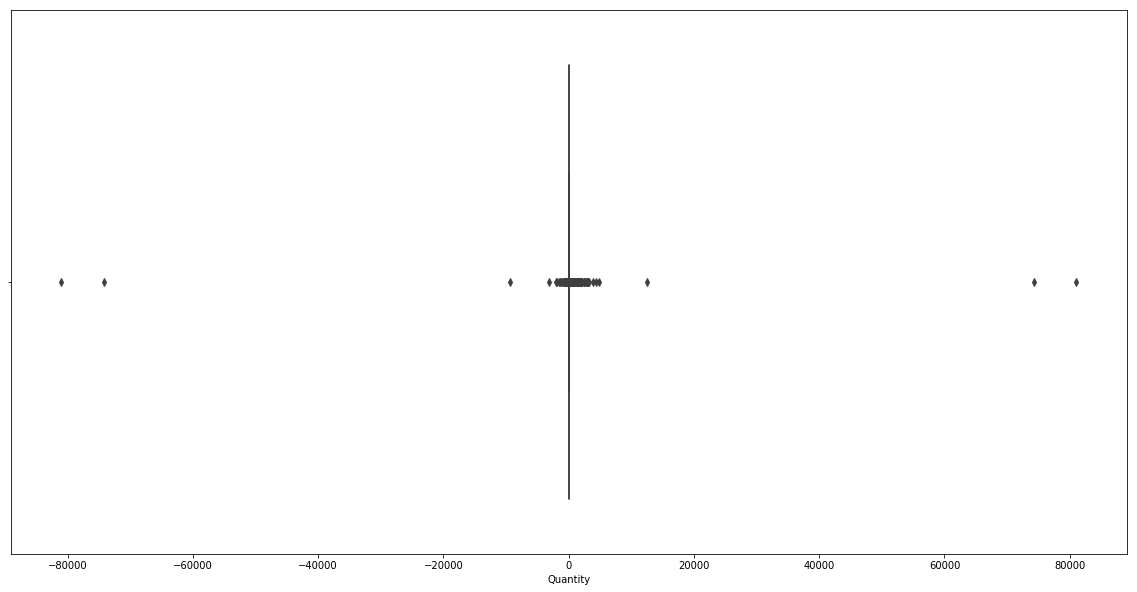

In [14]:
column_statistic('Quantity')

In [15]:
df[df['Quantity'] < 0].sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,Hour,StockValue
168293,C551015,21218,RED SPOTTY BISCUIT TIN,-10,2011-04-26 11:06:00,3.25,12753.0,Japan,2011,4,26,Tuesday,11,-32.50
403536,C571635,22659,LUNCH BOX I LOVE LONDON,-1,2011-10-18 11:39:00,1.95,16393.0,United Kingdom,2011,10,18,Tuesday,11,-1.95
414323,C572449,23393,HOME SWEET HOME CUSHION COVER,-2,2011-10-24 12:34:00,3.75,14428.0,United Kingdom,2011,10,24,Monday,12,-7.50
67506,C541834,85118,HEART T-LIGHT HOLDER,-6,2011-01-21 17:24:00,1.25,17048.0,United Kingdom,2011,1,21,Friday,17,-7.50
383056,C569994,84031A,CHARLIE+LOLA RED HOT WATER BOTTLE,-20,2011-10-06 20:33:00,1.95,15606.0,United Kingdom,2011,10,6,Thursday,20,-39.00


There are invoices which have negative number of quantity of some listings. As you can see those invoices have letter "C" at the beggining of invoice number. I suppose there are credit notes. Let's mark them. 2 listings with highest value of quantity have been turned back.

In [16]:
df['InvoiceType'] = df['InvoiceNo'].apply(lambda x: 'FK' if x[:1] == 'C' else 'FV')

count    406829.000000
mean          3.460471
std          69.315162
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       38970.000000
Name: UnitPrice, dtype: float64
----------
Variation coefficient 20.03055692478358
----------
Minimum values
187613    0.0
446794    0.0
298054    0.0
436961    0.0
436597    0.0
Name: UnitPrice, dtype: float64
Maximum values
222681    38970.00
173382     8142.75
173277     8142.75
173391     6930.00
268027     4287.63
Name: UnitPrice, dtype: float64


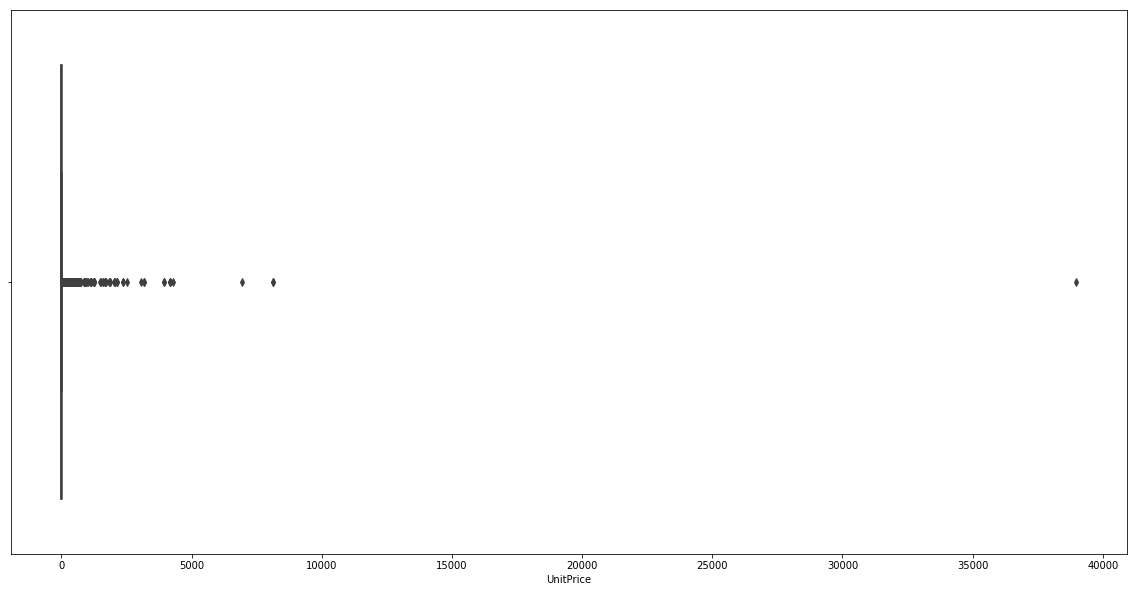

In [17]:
column_statistic('UnitPrice')

In [18]:
df[df['UnitPrice'] == 0].sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,Hour,StockValue,InvoiceType
439361,574469,22385,JUMBO BAG SPACEBOY DESIGN,12,2011-11-04 11:55:00,0.0,12431.0,Australia,2011,11,4,Friday,11,0.0,FV
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany,2010,12,5,Sunday,14,0.0,FV
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom,2010,12,16,Thursday,14,0.0,FV
479546,577168,M,Manual,1,2011-11-18 10:42:00,0.0,12603.0,Germany,2011,11,18,Friday,10,0.0,FV
479079,577129,22464,HANGING METAL HEART LANTERN,4,2011-11-17 19:52:00,0.0,15602.0,United Kingdom,2011,11,17,Thursday,19,0.0,FV


Some of the listings on invoices have 0 unit prices. It must be some kind of discounts or promotions.

In [19]:
group_type = df.groupby('InvoiceType')['InvoiceNo'].nunique()
print('We have got {0} invoices and {1} correcting invoices'.format(group_type[1],
                                                                    group_type[0]))
print('Its about {0} invoices and {1} correcting invoices per day'.format(group_type[1]/373,
                                                                        group_type[0]/373))

We have got 18536 invoices and 3654 correcting invoices
Its about 49.69436997319035 invoices and 9.796246648793566 correcting invoices per day


Total number of invoices is 22190, which 83,5% are sales invoices and the rest are credit notes.

There is 4372 customers who made 22190 transactions


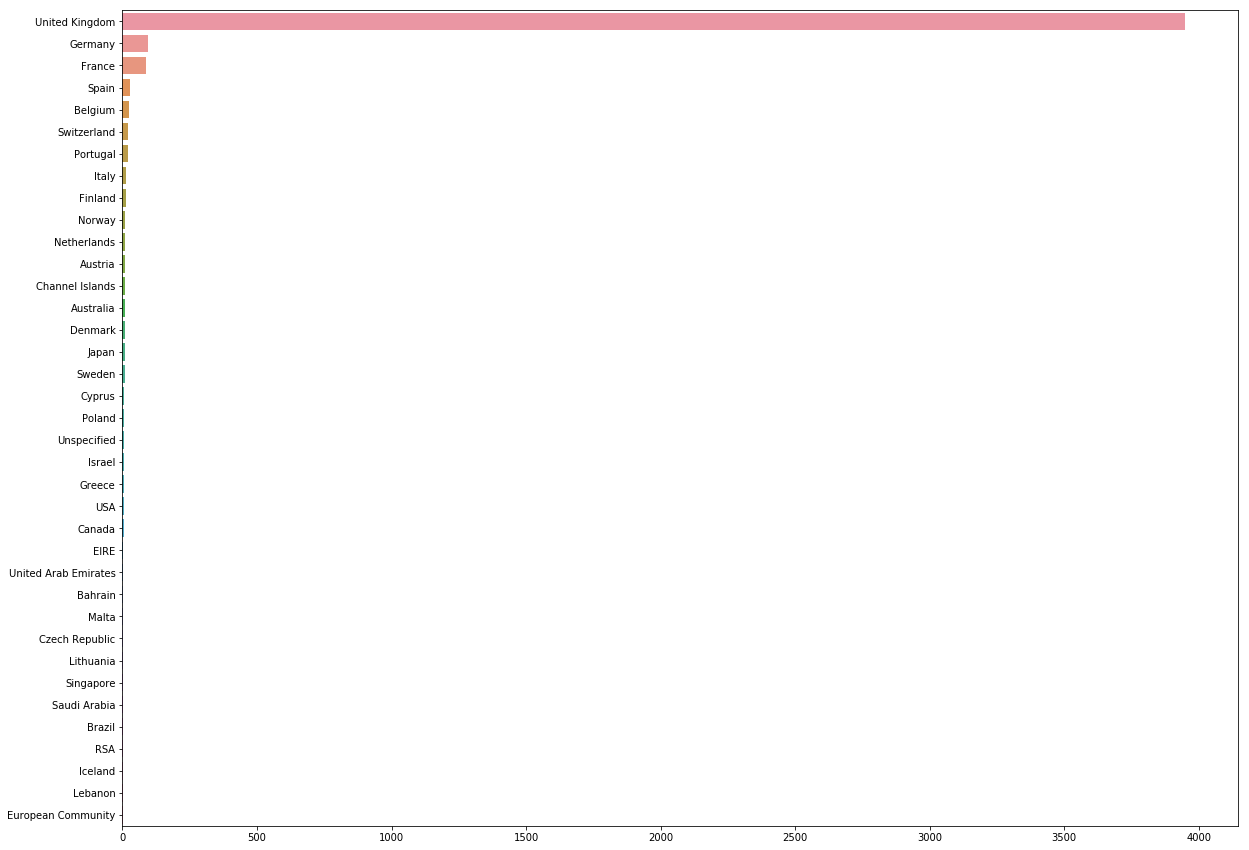

In [20]:
index = df['CustomerID'].drop_duplicates().index
df_unique_customer = df.loc[index, :]
unique_customer_count = df_unique_customer['Country'].value_counts()
#############
plt.figure(figsize=(20,15))
sns.barplot(y=unique_customer_count.index, x=unique_customer_count.values,
            order=unique_customer_count.index)
print('There is {} customers who made {} transactions'.format(len(df['CustomerID'].unique()),
                                                             len(df['InvoiceNo'].unique())))

Over 90% percent of customers are from United Kingdom.

In [21]:
stock_code_count = len(df['StockCode'].unique())
print('There is {} different stock codes'.format(stock_code_count))

There is 3684 different stock codes


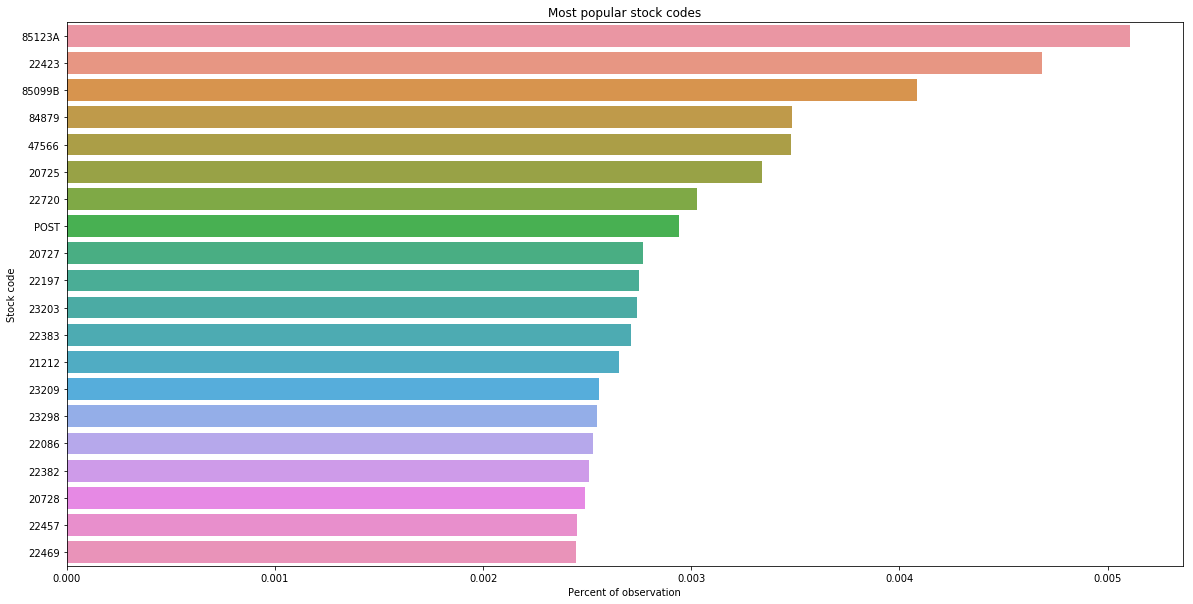

In [22]:
stock_code_v_counts = df['StockCode'].value_counts(normalize=True)[:20]
plt.figure(figsize=(20,10))
sns.barplot(y=stock_code_v_counts.index, x=stock_code_v_counts.values,
            order=stock_code_v_counts.index)
plt.title('Most popular stock codes')
plt.xlabel('Percent of observation')
plt.ylabel('Stock code')
plt.show()

Most of the stock codes are just numbers but some of them are some kind of text.

For the purpose of further analysis I will only include the sales invoices to avoid observations with negative quantity and will drop outliers.

In [23]:
df_low = df[df['InvoiceType'] == 'FV']
outlier_drop = df_low['StockValue'].quantile(0.95)
df_low = df_low[df_low['StockValue'] < outlier_drop]
print(df_low.shape[0]/df.shape[0])

0.9281614634158332


In [24]:
df_low['CustomerID'].nunique()

4224

After dropping 5% of data we lost a little more than 7% of observations.

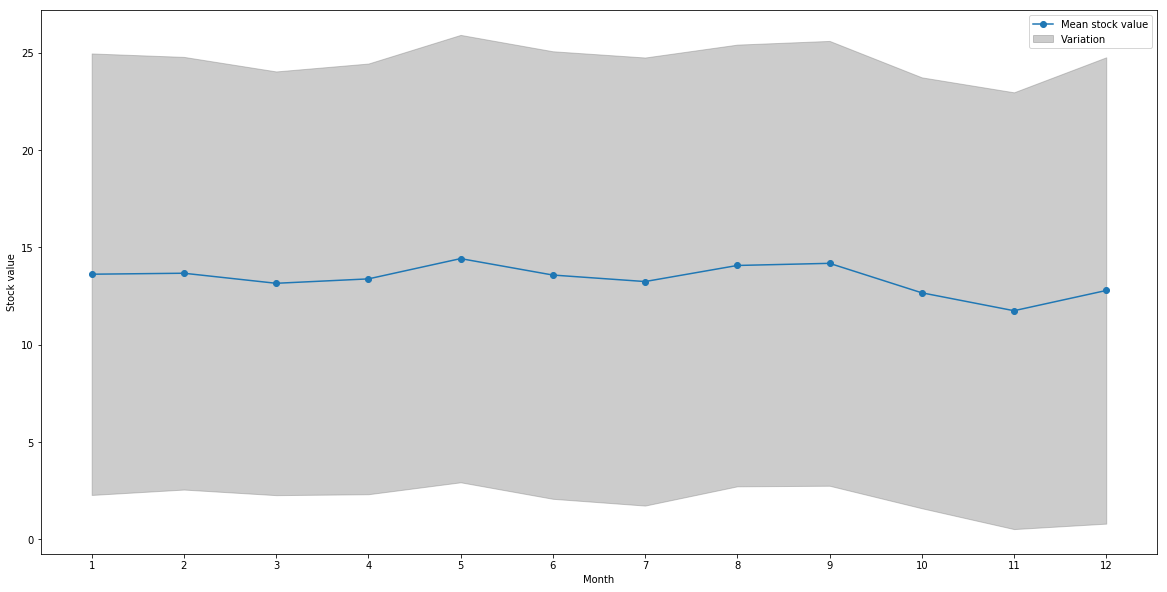

In [25]:
#df_low = df[((df['Quantity'] < 54) & (df['Quantity'] > 0)) & ((df['UnitPrice'] < 20))]
stock_value_group_mean = df_low['StockValue'].groupby(df_low['Month']).mean()
stock_value_group_std = df_low['StockValue'].groupby(df_low['Month']).std()
plt.figure(figsize=(20,10))
plt.plot(stock_value_group_mean, marker="o", label='Mean stock value')
plt.fill_between(stock_value_group_mean.index, stock_value_group_mean.values - stock_value_group_std.values, stock_value_group_mean.values + stock_value_group_std.values,
                 color='gray', alpha=0.4, label='Variation')
plt.xticks(np.linspace(1,12,12))
plt.xlabel('Month')
plt.ylabel('Stock value')
plt.legend()
plt.show()

In [26]:
df_low['StockValue'].mean()/df_low['StockValue'].std()

1.1590045309890775

The mean stock value over the year is constant. The variation coefficient is 1,15. Just to reminder in the not filtered data it was about 20~.

****RFM segmentation****

Next step is to cluster clients by RFM analysis (Recency, Frequency, Monetary). It groups customers based on their transaction history – how recently, how often and how much did they buy.

In [27]:
date = df_low['InvoiceDate'].max() + timedelta(days=1)

In [28]:
rfm = df_low.groupby(['CustomerID']).agg({'StockValue': lambda x: x.sum(),
                                'CustomerID': 'count',
                               'InvoiceDate': lambda x: (date-x.max()).days})
rfm.rename(columns={'StockValue': 'TotalMonetary',
                    'CustomerID': 'TotalTransactions',
                    'InvoiceDate': 'LastPurchase'}, inplace=True)
rfm.dropna(inplace=True)


print(rfm.shape[0])
rfm.head(5)

4224


,TotalMonetary,TotalTransactions,LastPurchase
CustomerID,,,
12347.0,3516.98,175,2.0
12348.0,803.24,23,75.0
12349.0,1457.55,72,19.0
12350.0,334.40,17,310.0
12352.0,1505.74,80,36.0


We still have 4224 unique customers to cluster. Table above shows 3 attribute that every customer will be clustered on.

TotalMonetary = total amount of cash that customer has spend

TotalTransactions = number of transactions for each customer

LastPurchase = number of days when was the last transaction

Right now every attribute get a score from 1 to 5 (the scale is dependent on the author) where 1 is best and 5 the worst. I'm about to get this score by dividing values into quantilies for each attribute. 

In [29]:
quantile = rfm.quantile(np.linspace(0,1,5))
quantile

,TotalMonetary,TotalTransactions,LastPurchase
0.00,0.0000,1.0,1.0
0.25,246.1975,17.0,18.0
0.50,552.3450,41.0,51.0
0.75,1337.5400,98.0,142.0
1.00,105160.1000,7817.0,374.0


In [30]:
def get_bins_monetary(x):
    if x <= quantile.loc[0, 'TotalMonetary']:
        return 5
    elif x <= quantile.loc[0.25, 'TotalMonetary']:
        return 4
    elif x <= quantile.loc[0.5, 'TotalMonetary']:
        return 3
    elif x <= quantile.loc[0.75, 'TotalMonetary']:
        return 2
    else:
        return 1
    
def get_bins_transactions(x):
    if x <= quantile.loc[0, 'TotalTransactions']:
        return 5
    elif x <= quantile.loc[0.25, 'TotalTransactions']:
        return 4
    elif x <= quantile.loc[0.5, 'TotalTransactions']:
        return 3
    elif x <= quantile.loc[0.75, 'TotalTransactions']:
        return 2
    else:
        return 1
    
def get_bins_purchase(x):
    if x <= quantile.loc[0, 'LastPurchase']:
        return 1
    elif x <= quantile.loc[0.25, 'LastPurchase']:
        return 2
    elif x <= quantile.loc[0.5, 'LastPurchase']:
        return 3
    elif x <= quantile.loc[0.75, 'LastPurchase']:
        return 4
    else:
        return 5

In [31]:
rfm['m_rate'] = rfm['TotalMonetary'].apply(get_bins_monetary)
rfm['f_rate'] = rfm['TotalTransactions'].apply(get_bins_transactions)
rfm['r_rate'] = rfm['LastPurchase'].apply(get_bins_purchase)
rfm['RFM'] = rfm['m_rate'].map(str) + rfm['f_rate'].map(str) + rfm['r_rate'].map(str)
rfm.head(10)

,TotalMonetary,TotalTransactions,LastPurchase,m_rate,f_rate,r_rate,RFM
CustomerID,,,,,,,
12347.0,3516.98,175,2.0,1,1,2,112
12348.0,803.24,23,75.0,2,3,4,234
12349.0,1457.55,72,19.0,1,2,3,123
12350.0,334.40,17,310.0,3,4,5,345
12352.0,1505.74,80,36.0,1,2,3,123
12353.0,89.00,4,204.0,4,4,5,445
12354.0,1079.40,58,232.0,2,2,5,225
12355.0,264.40,11,214.0,3,4,5,345
12356.0,1439.83,47,23.0,1,2,3,123


That's how the table looks like after signing every score

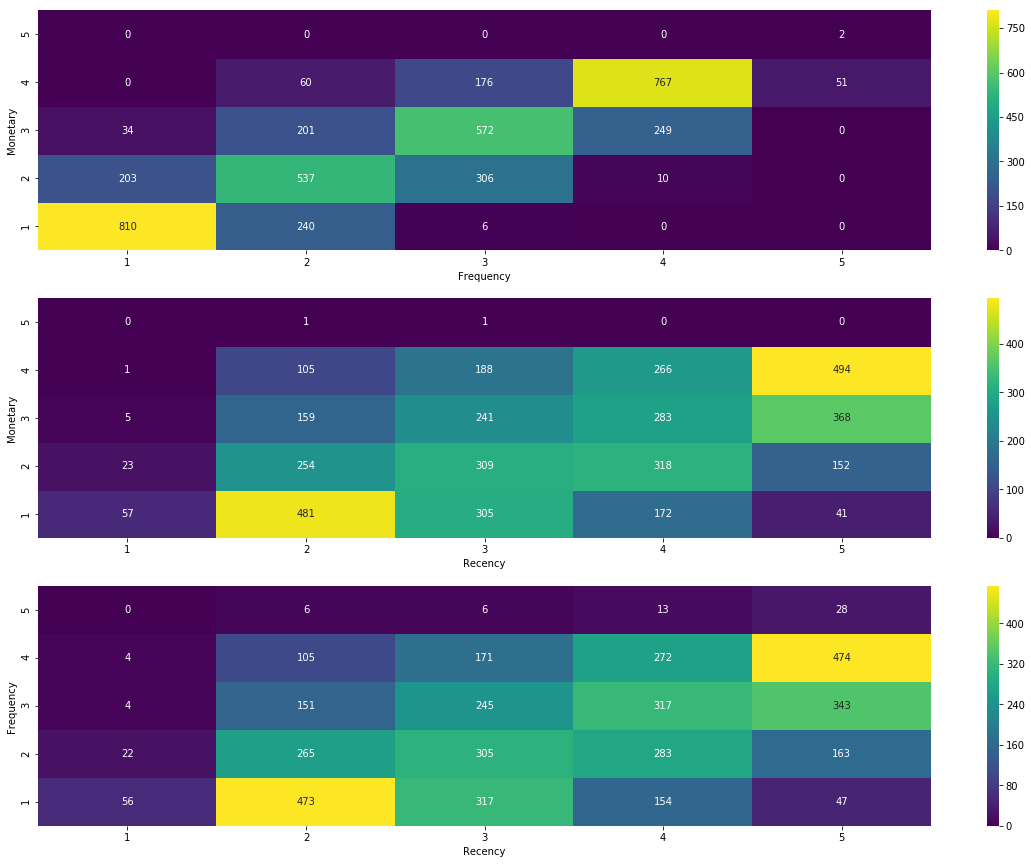

In [32]:
cross_table1 = pd.crosstab(index=rfm['m_rate'], columns=rfm['f_rate'])
cross_table2 = pd.crosstab(index=rfm['m_rate'], columns=rfm['r_rate'])
cross_table3 = pd.crosstab(index=rfm['f_rate'], columns=rfm['r_rate'])
plt.figure(figsize=(20,15))
plt.subplot(311)
ax1 = sns.heatmap(cross_table1, cmap='viridis', annot=True, fmt=".0f")
ax1.invert_yaxis()
ax1.set_ylabel('Monetary')
ax1.set_xlabel('Frequency')
plt.subplot(312)
ax2 = sns.heatmap(cross_table2, cmap='viridis', annot=True, fmt=".0f")
ax2.invert_yaxis()
ax2.set_ylabel('Monetary')
ax2.set_xlabel('Recency')
plt.subplot(313)
ax3 = sns.heatmap(cross_table3, cmap='viridis', annot=True, fmt=".0f")
ax3.invert_yaxis()
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Recency')
plt.show()

Above heatmaps show the cross table for every rating vs another rating. Looks like Monetary and Frequency is quite correlated with each other.